In [1]:
import pandas as pd, numpy as np
from rolling_framework import Machine

import warnings
warnings.filterwarnings('ignore')

/Users/ethan_hong/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'rolling_framework.base'

### Data Loading

In [ ]:
period = '19712018'

#%% Target variables : excess returns
y = pd.read_csv(f'data/{period}/exrets_{period}.csv', index_col='Time')             # Target : Excess Return (Bond Risk Premia)
y = y[['xr_2','xr_3','xr_4','xr_5','xr_6','xr_7','xr_8','xr_9','xr_10']]

#%% Predictors (Features)
FWDS = pd.read_csv(f'data/{period}/fwds_{period}.csv', index_col='Time')            # Forward Rates
MACV = pd.read_csv(f'data/{period}/MacroFactors_{period}.csv', index_col='Time')    # Ludvigson and Ng (2009), Macrovariables
LSC = pd.read_csv(f'data/{period}/lsc_{period}.csv', index_col='Time')              # Level, Slope and Curvature
# YLV = pd.read_csv(f'data/{period}/yl_{period}.csv', index_col='Time')               # yield-level
RVOL = pd.read_csv(f'data/{period}/real_vol_{period}.csv', index_col='Time')        # Realised Volatility 10yr
#IVOL = pd.read_csv(f'data/{period}/imp_vol_{period}.csv', index_col='Time')        # Implied Volatility (Work for 1990~)
CP = pd.read_csv(f'data/{period}/cp_{period}.csv', index_col='Time')                # Cochrane-Piazessi Factor
# YALL = pd.read_csv(f'data/{period}/yl_all_{period}.csv', index_col='Time')          # 12 m, 24 m, ... 120 m
# YMAX = pd.read_csv(f'data/{period}/yl_max_{period}.csv', index_col='Time')          # 1m ... 120 m

F6 = MACV[['F1','F2','F3','F4','F8','F1^3']]
SL = LSC[['slope']]
LV = LSC[['level']]
CU = LSC[['curvature']]


AGG = pd.concat([MACV, FWDS], axis=1)

AGG2 = pd.concat([SL, F6], axis=1)

OLS rolling: 100%|██████████| 360/360 [00:06<00:00, 58.61it/s]


xr_2    -0.119361
xr_3    -0.081308
xr_4    -0.044670
xr_5     0.002603
xr_7     0.058394
xr_10    0.141927
dtype: float64


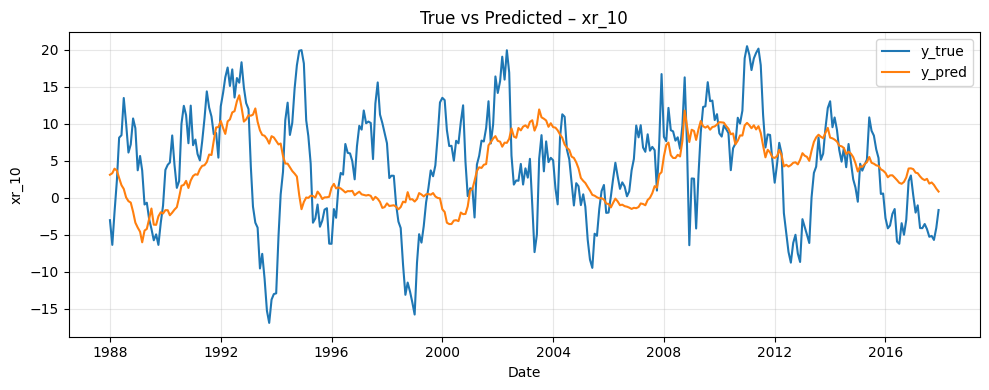

In [11]:
m = Machine(
    SL, y,
    model_type="OLS",
    forecast_horizon=11,
)
m.training()
print(m.R2OOS())
m.compare_plot("xr_10")

### DNN Experiment 1

In [ ]:
param_grid = {
    "dnn__module__hidden": [(3,),(2,),(1,)],    
    "dnn__module__dropout": [0.3,0.4,0.5],
    "dnn__lr": [0.01],
    "dnn__optimizer__weight_decay": [0.0005, 0.001, 0.0015],
}

m = Machine(
    FWDS, y,
    model_type="DNN",                  
    params_grid=param_grid,
    forecast_horizon=12,
    random_state=15
)
m.training()
print(m.R2OOS())
m.compare_plot("xr_10")

DNN rolling:   0%|          | 0/360 [00:00<?, ?it/s]

DNN rolling:  79%|███████▊  | 283/360 [4:03:39<1:23:02, 64.71s/it]

### DNN2 Experiments

In [ ]:
# ── 예시: dual-branch MLP 하이퍼파라미터 그리드 ─────────────────────────
param_grid = {
    # ── Branch-1 (예: 금리수급 변수 3개) ────────────────────────────────
    "dnn__module__hidden1": [(3,), (2,), (1,)],    # 얕은 vs. 두 층
    "dnn__module__drop1":   [0.3],       # 드롭아웃 비율

    # ── Branch-2 (예: 거시·거래량 변수 60개+) ───────────────────────────
    "dnn__module__hidden2": [(64,), (32,),(16,)],
    "dnn__module__drop2":   [0.3],

    # ── 공통 optimizer & regularization ────────────────────────────────
    "dnn__optimizer__lr":           [0.01],
    "dnn__optimizer__weight_decay": [0.0005, 0.0015]
}

grp1_cols = [c for c in AGG.columns if c.startswith("xr_")]
grp2_cols = [c for c in AGG.columns if c not in grp1_cols]

m = Machine(
    AGG, y,
    model_type="DNN_DUAL",
    option={"grp1": grp1_cols, "grp2": grp2_cols},
    params_grid=param_grid,
    forecast_horizon=12
)
m.training()
print(m.R2OOS())